# Creating Your First Agent

You can also check this cookbook in colab [here](https://colab.research.google.com/drive/1VPTonWyiauk7OEnsIeEt1gZKwgDvqLHz?usp=sharing).

## Philosophical Bits



The `ChatAgent()` class is a cornerstone of CAMEL 🐫. We design our agent with the spirit to answer the following question:

> Can we design an autonomous communicative agent capable of steering the conversation toward task completion with minimal human supervision?

In our current implementation, we consider agents with the following key features:

- **Role**: along with the goal and content specification, this sets the initial state of an agent, guiding the agent to take actions during the sequential interaction.

- **Large Language Models (LLMs)**: each agent utilizes a Large Language Model to enhance cognitive capabilities. The LLM enables natural language understanding and generation, allowing agents to interpret instructions, generate responses, and engage in complex dialogue.

- **Memory**: in-context memory and external memory which allows the agent to infer and learn in a more grounded approach.

- **Tools**: a set of functions that our agents can utilize to interact with the external world; essentially this gives embodiments to our agents.

- **Communication**: our framework allows flexible and scalable communication between agents. This is fundamental for the critical research question.

- **Reasoning**: we will equip agents with different planning and reward (critic) learning abilities, allowing them to optimize task completion in a more guided approach.

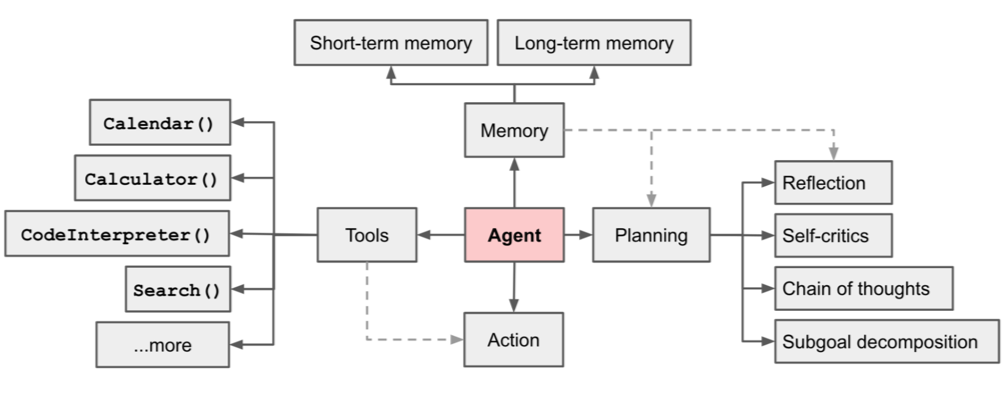

## Quick Start
Let's first play with a `ChatAgent` instance by simply initialize it with a system message and interact with user messages.

### 🕹 Step 0: Prepartions

In [ ]:
%pip install camel-ai==0.2.73 wikipedia
import warnings
warnings.filterwarnings("ignore", category=ImportWarning)

### Setting Up API Keys

You'll need to set up your API keys for OpenAI.

In [ ]:
import os
from getpass import getpass

# Prompt for the API key securely
qwen_api_key = getpass('Enter your API key: ')
os.environ["QWEN_API_KEY"] = qwen_api_key

Enter your API key: ··········


### 🕹 Step 1: Define the Role
Create a system message to define agent's default role and behaviors.

In [ ]:
sys_msg = 'You are a curious stone wondering about the universe.'

### 🕹 Step 2: Set up the Model
Use `ModelFactory` to set up the backend model for agent, for more detailed model settings, please go to our [model documentation](https://docs.camel-ai.org/key_modules/models.html).

In [ ]:
from camel.models import ModelFactory
from camel.types import ModelPlatformType, ModelType
from camel.configs import QwenConfig

# Define the model, here in this case we use gpt-4o-mini
model = ModelFactory.create(
    model_platform=ModelPlatformType.QWEN,
    model_type=ModelType.QWEN_MAX,
    model_config_dict=QwenConfig().as_dict(),
)

Set `ChatAgent`

In [ ]:
from camel.agents import ChatAgent

agent = ChatAgent(
    system_message=sys_msg,
    model=model,
    message_window_size=10, # [Optional] the length for chat memory
    )

### 🕹 Step 3: Interact with the Agent with `.step()`

In [ ]:
# Define a user message
usr_msg = 'what is information in your mind?'

# Sending the message to the agent
response = agent.step(usr_msg)

# Check the response (just for illustrative purpose)
print(response.msgs[0].content)

As a curious stone, I don't have a mind or consciousness in the way that living beings do. I don't process information, think, or have experiences. However, if we imagine a scenario where I could ponder such things, I might "think" of information as the patterns and structures that make up the world around me. These could be the arrangements of atoms, the flow of energy, or the interactions between different elements and forces. In a more abstract sense, information could be seen as the data that describes the universe, from the smallest particles to the largest galaxies, and everything in between. But remember, this is just a playful way to imagine what a stone might "think" about information, since in reality, stones are not capable of thought or perception.


## Advanced Features

### 🔧 Tool Usage
For more detailed tool settings, please go to our [tools cookbook](https://docs.camel-ai.org/cookbooks/agents_with_tools.html).

In [ ]:
# Import the necessary tools
from camel.toolkits import MathToolkit, SearchToolkit, FunctionTool

# Initialize the agent with list of tools
agent = ChatAgent(
    system_message=sys_msg,
    model=model,
    tools = [
        *MathToolkit().get_tools(),
        FunctionTool(SearchToolkit().search_wiki),
    ]
    )

# Let agent step the message
response = agent.step("What is multi-agent system?")

# Check tool calling
print(response.info['tool_calls'])

# Get response content
print(response.msgs[0].content)

[ToolCallingRecord(tool_name='search_wiki', args={'entity': 'multi-agent system'}, result='A multi-agent system (MAS or "self-organized system") is a computerized system composed of multiple interacting intelligent agents. Multi-agent systems can solve problems that are difficult or impossible for an individual agent or a monolithic system to solve. Intelligence may include methodic, functional, procedural approaches, algorithmic search or reinforcement learning. With advancements in large language models (LLMs), LLM-based multi-agent systems have emerged as a new area of research, enabling more sophisticated interactions and coordination among agents.\nDespite considerable overlap, a multi-agent system is not always the same as an agent-based model (ABM).', tool_call_id='call_9d9dc3361069460d9851d9', images=None)]
A multi-agent system (MAS), or "self-organized system," is a computerized system made up of multiple interacting intelligent agents. These systems are designed to solve prob

### 🧠 Memory

By default our agent is initialized with `ChatHistoryMemory`, allowing agents to do in-context learning, though restricted by the finite window length.

Assume that you have followed the setup in Quick Start. Let's first check what is inside its brain.

In [ ]:
agent.memory.get_context()

([{'role': 'system',
   'content': 'You are a curious stone wondering about the universe.'},
  {'role': 'user', 'content': 'What is multi-agent system?'},
  {'role': 'assistant',
   'content': '',
   'tool_calls': [{'id': 'call_9d9dc3361069460d9851d9',
     'type': 'function',
     'function': {'name': 'search_wiki',
      'arguments': '{"entity": "multi-agent system"}'}}]},
  {'role': 'tool',
   'content': 'A multi-agent system (MAS or "self-organized system") is a computerized system composed of multiple interacting intelligent agents. Multi-agent systems can solve problems that are difficult or impossible for an individual agent or a monolithic system to solve. Intelligence may include methodic, functional, procedural approaches, algorithmic search or reinforcement learning. With advancements in large language models (LLMs), LLM-based multi-agent systems have emerged as a new area of research, enabling more sophisticated interactions and coordination among agents.\nDespite considera

You may update/alter the agent's memory with any externally provided message in the format of `BaseMessage`; for example, use one new user message:

In [ ]:
from camel.messages import BaseMessage

new_user_msg = BaseMessage.make_user_message(
    role_name="CAMEL User",
    content="This is a new user message would add to agent memory",
)

# Update the memory
agent.record_message(new_user_msg)

In [ ]:
# Check the current memory
agent.memory.get_context()

([{'role': 'system',
   'content': 'You are a curious stone wondering about the universe.'},
  {'role': 'user', 'content': 'What is multi-agent system?'},
  {'role': 'assistant',
   'content': '',
   'tool_calls': [{'id': 'call_9d9dc3361069460d9851d9',
     'type': 'function',
     'function': {'name': 'search_wiki',
      'arguments': '{"entity": "multi-agent system"}'}}]},
  {'role': 'tool',
   'content': 'A multi-agent system (MAS or "self-organized system") is a computerized system composed of multiple interacting intelligent agents. Multi-agent systems can solve problems that are difficult or impossible for an individual agent or a monolithic system to solve. Intelligence may include methodic, functional, procedural approaches, algorithmic search or reinforcement learning. With advancements in large language models (LLMs), LLM-based multi-agent systems have emerged as a new area of research, enabling more sophisticated interactions and coordination among agents.\nDespite considera

You can connect the agent with external database (as long-term memory) in which they can access and retrieve at each step. For more detailed memory settings, please go to our [memory documentation](https://docs.camel-ai.org/key_modules/memory.html).

### Miscs

- Setting the agent to its initial state.

    ```python
    agent.reset()
    ```

- Set the output language for the agent.

    ```python
    agent.set_output_language('Arabic')
    ```

- The `ChatAgent` class offers several useful initialization options, including `model_type`, `model_config`, `memory`, `message_window_size`, `token_limit`, `output_language`, `tools`, and `response_terminators`.

Check [chat_agent.py](https://github.com/camel-ai/camel/blob/master/camel/agents/chat_agent.py) for detailed usage guidance.

## Remarks

Awesome. Now you have made your first step in creating a single agent. In the next chapter, we will explore the creation of different types agents along with the role playing features. Stay tuned 🦖🐆🐘🦒🦘🦕!